In [94]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [95]:
# Get test trajectories from the env, verify that these are the same as the ones used in the training of the data
from worldllm_envs.playground.playground_text_wrapper import PlayGroundText


test_trajectories = PlayGroundText.get_test_dataset()
# Keep only the scorable observations
test_observations = []
for trajectory in test_trajectories:
    for incr, observation in enumerate(trajectory.text):
        if incr % 2 ==0 and incr != 0:
            test_observations.append(observation)
nb_transitions = len(test_observations)

In [96]:
# Load the data


shared_extension = ""
baselines_to_load = [
    "playground_metropolis_pb",
    "playground_metropolis_phi_phi",
    "playground_metropolis_rb",
    "playground_metropolis_cp",
]
baselines_names = ["M2 PB", "M2 1it", "M2 RB", "M2 CP"]
all_data = {k: [] for k in baselines_names}
all_rules = {}
all_likelihoods = {}
all_transition_likelihoods = {}
all_weights = {}
all_additional_data = {}
for baseline, b_name in zip(baselines_to_load, baselines_names):
    print(
        "-------------------------------- Load "
        + baseline
        + " --------------------------------"
    )
    path_start = "./outputs/" + baseline + shared_extension + "/"
    lst_data = []
    for f_day in os.listdir(path_start):
        if os.path.isdir(path_start + f_day):
            for f_hour in os.listdir(path_start + f_day):
                if os.path.isdir(path_start + f_day + "/" + f_hour):
                    path = path_start + f_day + "/" + f_hour + "/all.json"
                    with open(path, "r") as file:
                        lst_data.append(json.load(file))
                        print("Loaded: " + path)
    # Reconstruct all rules and parse by seeds
    if "counts" in lst_data[0]["metrics"]:
        # Parse IS
        rules = []
        likelihoods = []
        transition_likelihoods = []
        weights = []
        for data in lst_data:
            rules.append(np.repeat(data["rules"], data["metrics"]["counts"]))
            likelihoods.append(
                np.repeat(
                    data["metrics"]["test_likelihoods"], data["metrics"]["counts"]
                )
            )
            weights.append(
                np.repeat(data["metrics"]["weights"], data["metrics"]["counts"])
            )
            transitions = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores"]:
                transitions.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            transition_likelihoods.append(np.repeat(transitions, data["metrics"]["counts"]))
                
        all_rules[b_name] = np.stack(rules)
        all_likelihoods[b_name] = np.stack(likelihoods)
        all_transition_likelihoods[b_name] = np.stack(transition_likelihoods)
        all_weights[b_name] = np.stack(weights)
    elif "prev_rules_ind" in lst_data[0]["metrics"]:
        # Parse Metropolis
        # Reconstruct all rules M
        reshaped_rules = []
        reshaped_likelihoods = []
        reshaped_transition_likelihoods = []
        reshaped_weights = []
        reshaped_prev_rules_ind = []
        for data in lst_data:
            # TODO: remove hardcoded default rule to 3
            nb_particles = (
                data["metrics"]["nb_rules"] if "nb_rules" in data["metrics"] else 3
            )
            rules = np.array(data["rules"])
            likelihoods = np.array(data["metrics"]["test_likelihoods"])
            weights = np.array(data["metrics"]["weights"])
            prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
            transition_likelihoods = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores"]:
                transition_likelihoods.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            assert len([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood]) == nb_transitions
            #Reshape to consider particle as different seeds
            reshaped_rules.append(rules.reshape((-1, nb_particles)).transpose())
            reshaped_likelihoods.append(
                likelihoods.reshape((-1, nb_particles)).transpose()
            )
            reshaped_weights.append(weights.reshape((-1, nb_particles)).transpose())
            reshaped_prev_rules_ind.append(
                prev_rules_ind.reshape((-1, nb_particles)).transpose()
            )
            reshaped_transition_likelihoods.append(
                np.array(transition_likelihoods).reshape((-1,nb_particles,nb_transitions)).transpose((1,0,2))
            )
        # Concatenate all seeds
        all_rules[b_name] = np.concatenate(reshaped_rules, axis=0)
        all_likelihoods[b_name] = np.concatenate(reshaped_likelihoods, axis=0)
        all_weights[b_name] = np.concatenate(reshaped_weights, axis=0)
        all_additional_data[b_name] = {
            "prev_rules_ind": np.concatenate(reshaped_prev_rules_ind, axis=0)
        }
        all_transition_likelihoods[b_name] = np.concatenate(reshaped_transition_likelihoods, axis=0)
    else:
        raise ValueError("Unknown format")
    all_data[b_name] = lst_data

-------------------------------- Load playground_metropolis_pb --------------------------------
Loaded: ./outputs/playground_metropolis_pb/2024-09-13/20-06-49_439/all.json
Loaded: ./outputs/playground_metropolis_pb/2024-09-13/20-06-47_438/all.json
-------------------------------- Load playground_metropolis_phi_phi --------------------------------
Loaded: ./outputs/playground_metropolis_phi_phi/2024-09-13/20-06-48_438/all.json
Loaded: ./outputs/playground_metropolis_phi_phi/2024-09-13/20-06-47_439/all.json
-------------------------------- Load playground_metropolis_rb --------------------------------
Loaded: ./outputs/playground_metropolis_rb/2024-09-13/20-06-46_440/all.json
Loaded: ./outputs/playground_metropolis_rb/2024-09-13/20-06-46_441/all.json
-------------------------------- Load playground_metropolis_cp --------------------------------
Loaded: ./outputs/playground_metropolis_cp/2024-09-13/20-06-47_443/all.json
Loaded: ./outputs/playground_metropolis_cp/2024-09-13/20-06-46_442/al

## Analyze the prediction of certain transition

In [97]:
dict_index_transition = {"standing": [], "holding": [], "holding1": [], "holding2": [], "transform":[], "transformP": [], "transformSH": [], "transformBH": [], "nothing": []}
for incr,transition in enumerate(test_observations):
    if "standing" in transition:
        dict_index_transition["standing"].append(incr)
    elif "holding" in transition:
        if " and " in transition:
            dict_index_transition["holding2"].append(incr)
        else:
            dict_index_transition["holding1"].append(incr)
        dict_index_transition["holding"].append(incr)
    elif "transform" in transition:
        if "into the carrot" in transition or "into the potato." in transition or "into the beet." in transition or "into the berry." in transition or "into the pea." in transition:
            dict_index_transition["transformP"].append(incr)
        elif "into the pig." in transition or "into the cow." in transition or "into the sheep." in transition:
            dict_index_transition["transformSH"].append(incr)
        elif "into the elephant." in transition or "into the giraffe." in transition or "into the rhinoceros." in transition:
            dict_index_transition["transformBH"].append(incr)
        else:
            raise ValueError("Unknown transform")
        dict_index_transition["transform"].append(incr)
    elif "Nothing" in transition:
        dict_index_transition["nothing"].append(incr)
    else:
        raise ValueError("Unknown transition")

In [98]:
# Get repartition of the actions:
for action in dict_index_transition:
    print(action, len(dict_index_transition[action]))

standing 27
holding 13
holding1 7
holding2 6
transform 8
transformP 6
transformSH 1
transformBH 1
nothing 15


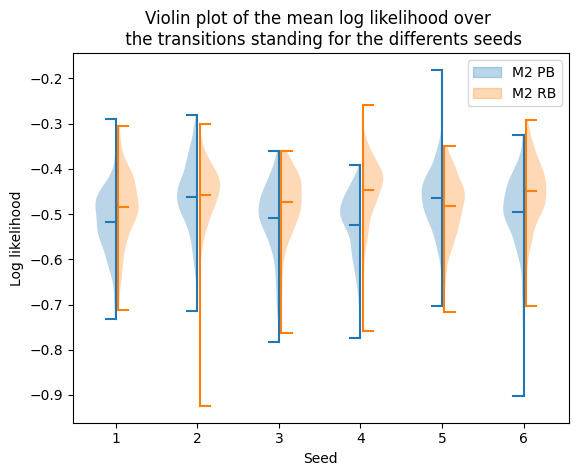

In [99]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms only on some transitions
first_baseline = "M2 PB"
second_baseline = "M2 RB"
transition_type = "standing"
plt.figure()
color1 = plt.violinplot(all_transition_likelihoods[first_baseline][:,:,dict_index_transition[transition_type]].mean(axis=2).transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color1 = matplotlib.patches.Patch(color=color1)
color2 = plt.violinplot(all_transition_likelihoods[second_baseline][:,:,dict_index_transition[transition_type]].mean(axis=2).transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods[b_name]))])["bodies"][0].get_facecolor().flatten()
color2 = matplotlib.patches.Patch(color=color2)
plt.legend([color1, color2], [first_baseline, second_baseline])
plt.title(f"Violin plot of the mean log likelihood over \n the transitions {transition_type} for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

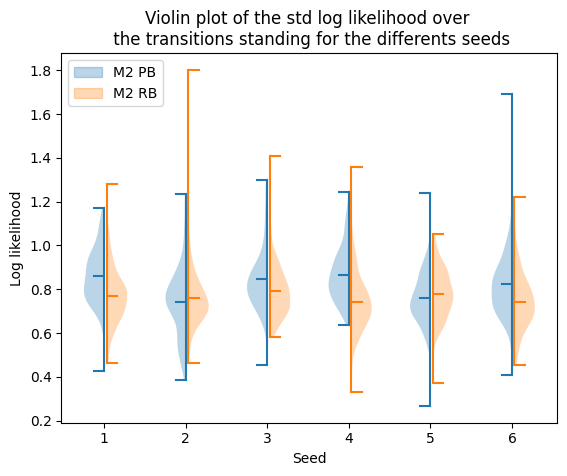

In [100]:
plt.figure()
color1 = plt.violinplot(all_transition_likelihoods[first_baseline][:,:,dict_index_transition[transition_type]].std(axis=2).transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color1 = matplotlib.patches.Patch(color=color1)
color2 = plt.violinplot(all_transition_likelihoods[second_baseline][:,:,dict_index_transition[transition_type]].std(axis=2).transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods[b_name]))])["bodies"][0].get_facecolor().flatten()
color2 = matplotlib.patches.Patch(color=color2)
plt.legend([color1, color2], [first_baseline, second_baseline])
plt.title(f"Violin plot of the std log likelihood over \n the transitions {transition_type} for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()